In [2]:
!pip install msprt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
msprt 0.1.2 requires numpy<2.0.0,>=1.26.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.


In [3]:
from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5, palette='Set2')
import tqdm
from scipy import stats
from msprt import msprt

In [ ]:
#t-test
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)

    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    t_stat = difference_mean/np.sqrt(difference_mean_var)
    t_stat_distribution = sps.norm(loc=0, scale=1)
    pvalue = t_stat_distribution.cdf(t_stat)
    return [pvalue, t_stat]




# returns new samples after transformation in CUPED
def cuped_ttest(control, test, control_before, test_before):
    theta = (np.cov(control, control_before)[0, 1] + np.cov(test, test_before)[0, 1]) /\
                (np.var(control_before) + np.var(test_before))

    control_cup = control - theta * control_before
    test_cup = test - theta * test_before

    return [control_cup, test_cup]

#realization of t-test
def strat_ttest(AB_data,strates):
    means_control = AB_data.loc[AB_data['ab_version']=='control'].groupby(strates).agg({'value':'mean'})
    varrs_control = AB_data.loc[AB_data['ab_version']=='control'].groupby(strates).agg({'value':'var'})
    means_test = AB_data.loc[AB_data['ab_version']=='test'].groupby(strates).agg({'value':'mean'})
    varrs_test = AB_data.loc[AB_data['ab_version']=='test'].groupby(strates).agg({'value':'var'})
    weights = AB_data.groupby(strates).agg({'value':'count'})/len(AB_data)
    strat_mean_control = (means_control.mul(weights).sum()).value
    strat_mean_test = (means_test.mul(weights).sum()).value
    strat_var_control = (varrs_control.mul(weights).sum()/len(AB_data.loc[AB_data['ab_version']=='control'])).value
    strat_var_test = (varrs_test.mul(weights).sum()/len(AB_data.loc[AB_data['ab_version']=='test'])).value
    t_stat = (strat_mean_test-strat_mean_control)/np.sqrt(strat_var_test+strat_var_control)
    t_stat_distribution = sps.norm(loc=0, scale=1)
    p_value = t_stat_distribution.cdf(t_stat)
    return [p_value,t_stat]

In [ ]:
#msprt
def get_msprt(control, test, distribution,theta):
    res = msprt(control,test, distribution = distribution, sigma = np.std(control), theta = theta)
    if(res.decision == 'Accept H1'):
        return [1, res.n_rejection]
    else:
        return [0, res.n_rejection]

In [ ]:
#realization of bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    graph = False, # показывать ли визуализацию
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = np.random.choice(data_column_1,size = boot_len, replace = True)
        samples_2 = np.random.choice(data_column_2,size = boot_len, replace = True)


        boot_data.append(statistic(samples_1) - statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    quant = pd_boot_data.quantile([bootstrap_conf_level])
    p_value = stats.norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )

    # Визуализация
    if(graph is True):
        _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
        for bar in bars:
            if bar.get_x() >= quant.iloc[0][0]:
                bar.set_facecolor('red')
            else:
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('ggplot')
        plt.vlines(quant,ymin = 0,ymax = 50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.rcParams['figure.figsize'] = [14, 8]
        plt.show()

    return p_value

In [ ]:
#sample size
def ttest_sample_size(control, mde, sig=0.05, power=0.8):
    control_var = np.var(control)
    test_var = control_var
    mde = np.mean(control)*mde
    z_power, z_sig = sps.norm.ppf([1-power, 1-sig])
    n = round((test_var+control_var)*((z_sig-z_power)**2)/(mde**2))
    return n

In [ ]:
#simulation of the A/B test for the criterion msprt
def msprt_AB_simulation(AB_data):
    sig = 0.05
    power = 0.8
    control = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value'].values) # сюда вставляем выборку полученную на основе реальных данных
    control_mean = control.mean()
    rel_mde_list = [0.06, 0.05, 0.04, 0.03, 0.02]
    N = 100
    power_list = []
    empirical_power_list = []
    mde_list = []
    sample_size_list = []
    left_real_level_list = []
    right_real_level_list = []

    for rel_mde in (rel_mde_list):
        fake_test = control - control_mean*rel_mde
        results = []
        n = []
        for i in (range(N)):
            sample_a = np.random.choice(control, size=min(len(control),len(fake_test)), replace=True)
            sample_b = np.random.choice(fake_test, size=min(len(control),len(fake_test)), replace=True)
            res = get_msprt(sample_a, sample_b, distribution = 'normal', theta=0.5)
            results.append(res[0])
            n.append(res[1])

        power_list.append(power)
        empirical_power_list.append(np.mean(results))
        mde_list.append(rel_mde)
        sample_size_list.append(np.mean(n))
        left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
        left_real_level_list.append(left_real_level)
        right_real_level_list.append(right_real_level)

    power_df_real = pd.DataFrame(columns=['power', 'empirical_power',
                                                    'mde', 'sample_size',
                                                    'left_real_level', 'right_real_level'])
    power_df_real['power'] = power_list
    power_df_real['empirical_power'] = empirical_power_list
    power_df_real['mde'] = mde_list
    power_df_real['sample_size'] = sample_size_list
    power_df_real['left_real_level'] = left_real_level_list
    power_df_real['right_real_level'] = right_real_level_list
    return power_df_real

In [ ]:
#simulation of the A/A test for the criterionя msprt
def msprt_AA_simulation(AB_data):
    sig = 0.05
    power = 0.8

    control = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values) # сюда вставляем выборку полученную на основе реальных данных
    fake_test = np.array(AB_data.loc[(AB_data['ab_version']=='test'),'value_before'].values)
    rel_mde_list = [0.06, 0.05, 0.04, 0.03, 0.02] # относительные значения прироста (относительный MDE)

    N = 1000
    n = []
    results = []
    for i in (range(N)):
        sample_a = np.random.choice(control, size=min(len(control),len(fake_test)), replace=True)
        sample_b = np.random.choice(fake_test, size=min(len(control),len(fake_test)), replace=True)
        res = get_msprt(sample_a, sample_b, distribution = 'normal', theta=0.5)
        results.append(res[0])
        n.append(res[1])

    left_real_level, right_real_level = proportion_confint(count=N*np.mean(results),
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
    sig_df_real = pd.DataFrame(columns=['sig', 'empirical_sig', 'sample_size',
                                                    'left_real_level', 'right_real_level'])
    sig_df_real['sig'] = [sig]
    sig_df_real['empirical_sig'] = np.mean(results)
    sig_df_real['sample_size'] = np.mean(n)
    sig_df_real['left_real_level'] = left_real_level
    sig_df_real['right_real_level'] = right_real_level
    return sig_df_real

In [ ]:
#A/B test simulation
def AB_simulation(AB_data,criterion,strates = ''):
    sig = 0.05
    power = 0.8
    z_power, z_sig = sps.norm.ppf([1-power, 1-sig])

    control = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value'].values) # сюда вставляем выборку полученную на основе реальных данных
    control_before = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values)
    control_mean = control.mean()

    rel_mde_list = [0.06, 0.05, 0.04, 0.03, 0.02] # относительные значения прироста (относительный MDE)

    N = 100

    power_list = []
    empirical_power_list = []
    mde_list = []
    sample_size_list = []
    left_real_level_list = []
    right_real_level_list = []

    for rel_mde in (rel_mde_list):
        if(criterion != 'strat_ttest'):
            fake_test = control - control_mean*rel_mde #добавляем именно так из-за формулы для размера выборки
        if(criterion == 'bootstrap' or criterion == 'ttest'):
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
        elif(criterion == 'cuped_ttest'):
            #lets use the same formula here
            #if we try to use correct formula for sample size for CUPED we get very big number
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
        elif(criterion == 'strat_ttest'):
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
            weights = (round(n*AB_data.groupby(strates).agg({'value':'count'})/len(AB_data))).to_dict()['value']

        results = []

        for i in (range(N)):
            if(criterion!='strat_ttest' and criterion!='cuped_ttest'):
                sample_a = np.random.choice(control, size=n, replace=True) #было False
                sample_b = np.random.choice(fake_test, size=n, replace=True)
            if(criterion == 'bootstrap'):
                res = [get_bootstrap(sample_a, sample_b)]
            elif(criterion == 'ttest'):
                res = absolute_ttest(sample_a, sample_b)
            elif(criterion == 'strat_ttest'):
                temp = AB_data.loc[(AB_data['ab_version']=='control')]
                sampled_AB_test = pd.concat([temp[temp[strates]==key].sample(n=int(value), replace=True) for key, value in weights.items()])
                sampled_AB_fake_test = pd.concat([temp[temp[strates]==key].sample(n=int(value), replace=True) for key, value in weights.items()])
                sampled_AB_fake_test['value'] = sampled_AB_fake_test['value'] - control_mean*rel_mde
                sampled_AB_fake_test['ab_version'] = 'test'
                sampled_AB = pd.concat([sampled_AB_test, sampled_AB_fake_test])
                res = strat_ttest(sampled_AB,strates)
            elif(criterion == 'cuped_ttest'):
                sample_a = np.random.choice(cuped_ttest(control, fake_test, control_before, control_before)[0], size=n, replace=True)
                sample_b = np.random.choice(cuped_ttest(control, fake_test, control_before, control_before)[1], size=n, replace=True)
                res = absolute_ttest(sample_a, sample_b)
            if(res[0]<=0.05):
                results.append(1)
            else:
                results.append(0)

        power_list.append(power)
        empirical_power_list.append(np.mean(results))
        mde_list.append(rel_mde)
        sample_size_list.append(n)
        left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
        left_real_level_list.append(left_real_level)
        right_real_level_list.append(right_real_level)

    power_df_real = pd.DataFrame(columns=['power', 'empirical_power',
                                                    'mde', 'sample_size',
                                                    'left_real_level', 'right_real_level'])
    power_df_real['power'] = power_list
    power_df_real['empirical_power'] = empirical_power_list
    power_df_real['mde'] = mde_list
    power_df_real['sample_size'] = sample_size_list
    power_df_real['left_real_level'] = left_real_level_list
    power_df_real['right_real_level'] = right_real_level_list
    return power_df_real

In [ ]:
#A/A test simulation
def AA_simulation(AB_data,criterion, strates = ''):
    sig = 0.05
    power = 0.8
    z_power, z_sig = sps.norm.ppf([1-power, 1-sig])

    control = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value'].values) # сюда вставляем выборку полученную на основе реальных данных
    control_before = np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values)
    control_mean = control.mean()

    rel_mde_list = [0.06, 0.05, 0.04, 0.03, 0.02] # относительные значения прироста (относительный MDE)

    N = 100

    sig_list = []
    empirical_sig_list = []
    mde_list = []
    sample_size_list = []
    left_real_level_list = []
    right_real_level_list = []

    for rel_mde in (rel_mde_list):
        if(criterion != 'strat_ttest'):
            fake_test = control

        if(criterion == 'bootstrap' or criterion == 'ttest'):
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
        elif(criterion == 'cuped_ttest'):
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
        elif(criterion == 'strat_ttest'):
            n = ttest_sample_size(control, rel_mde, 0.05, 0.8)
            weights = (round(n*AB_data.groupby(strates).agg({'value':'count'})/len(AB_data))).to_dict()['value']

        results = []

        for i in (range(N)):
            if(criterion!='strat_ttest' and criterion!='cuped_ttest'):
                sample_a = np.random.choice(control, size=n, replace=True)
                sample_b = np.random.choice(fake_test, size=n, replace=True)

            if(criterion == 'bootstrap'):
                res = [get_bootstrap(sample_a, sample_b)]
            elif(criterion == 'ttest'):
                res = absolute_ttest(sample_a, sample_b)
            elif(criterion == 'strat_ttest'):
                temp = AB_data.loc[(AB_data['ab_version']=='control')]
                sampled_AB_test = pd.concat([temp[temp[strates]==key].sample(n=int(value), replace=True) for key, value in weights.items()])
                sampled_AB_fake_test = pd.concat([temp[temp[strates]==key].sample(n=int(value), replace=True) for key, value in weights.items()])
                sampled_AB_fake_test['ab_version'] = 'test'
                sampled_AB = pd.concat([sampled_AB_test, sampled_AB_fake_test])
                res = strat_ttest(sampled_AB,strates)
            elif(criterion == 'cuped_ttest'):
                sample_a = np.random.choice(cuped_ttest(control, fake_test, control_before, control_before)[0], size=n, replace=True)
                sample_b = np.random.choice(cuped_ttest(control, fake_test, control_before, control_before)[1], size=n, replace=True)
                res = absolute_ttest(sample_a, sample_b)

            if res[0]<=0.05:
                results.append(1)
            else:
                results.append(0)

        sig_list.append(sig)
        empirical_sig_list.append(np.mean(results))
        mde_list.append(rel_mde)
        sample_size_list.append(n)
        left_real_level, right_real_level = proportion_confint(count=N*empirical_sig_list[-1],
                                                               nobs=N,
                                                               alpha=0.05,
                                                               method='wilson')
        left_real_level_list.append(left_real_level)
        right_real_level_list.append(right_real_level)

    sig_df_real = pd.DataFrame(columns=['sig', 'empirical_sig',
                                                    'mde', 'sample_size',
                                                    'left_real_level', 'right_real_level'])
    sig_df_real['sig'] = sig_list
    sig_df_real['empirical_sig'] = empirical_sig_list
    sig_df_real['mde'] = mde_list
    sig_df_real['sample_size'] = sample_size_list
    sig_df_real['left_real_level'] = left_real_level_list
    sig_df_real['right_real_level'] = right_real_level_list
    return sig_df_real

In [14]:
AB_data = pd.read_csv('duration_of_session.csv', sep=',')

In [7]:
AB_data

,device,source,ab_version,value,value_before
0,Mobile,Source1,control,308.377438,311.340360
1,Mobile,Source1,control,327.119029,330.815699
2,Mobile,Source1,control,300.569840,285.810552
3,Mobile,Source1,control,439.302992,448.885044
4,Mobile,Source1,control,276.619039,280.341642
...,...,...,...,...,...
3003,Desktop,Source3,test,267.150356,283.496529
3004,Desktop,Source3,test,260.763262,271.919014
3005,Desktop,Source3,test,345.410728,363.250994
3006,Desktop,Source3,test,280.789818,293.557435


In [12]:
AB_data.groupby(['ab_version','source']).agg({'value':['count','mean','std']})

value                       
                   count        mean        std
ab_version source                              
control    Source1   204  330.382289  58.493970
           Source2   595  336.573549  58.632682
           Source3   734  323.082672  55.110090
test       Source1   209  319.498411  53.065154
           Source2   523  320.919833  53.641930
           Source3   743  308.554364  53.078183

In [ ]:
AB_data.groupby('ab_version').agg({'value':['count','mean','std']})

value                       
           count        mean        std
ab_version                             
control     1533  331.198450  57.421284
test        1475  314.222026  54.423169

In [ ]:
AB_data.groupby(['ab_version','source']).agg({'value':['count','mean','std']})

value                       
                   count        mean        std
ab_version source                              
control    Source1   204  337.202754  60.568547
           Source2   595  338.789279  58.684842
           Source3   734  323.376350  54.464641
test       Source1   209  322.723489  57.599522
           Source2   523  321.306666  57.514582
           Source3   743  306.843732  50.163992

In [ ]:
AB_data.groupby(['ab_version','device']).agg({'value':['count','mean','std']})

value                       
                   count        mean        std
ab_version device                              
control    Desktop  1238  332.209315  57.490743
           Mobile    295  326.956244  57.030480
test       Desktop  1161  315.145845  54.264718
           Mobile    314  310.806247  54.957239

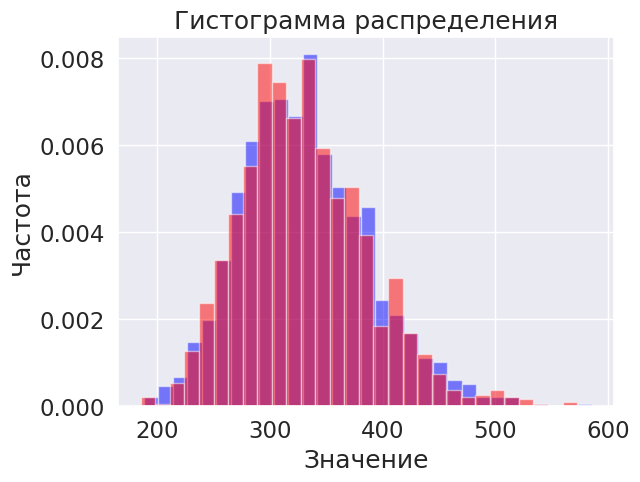

In [ ]:
#distributions for test and control in past
plt.hist(np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values), bins='auto', density = True,color = 'blue',alpha = 0.5)
plt.hist(AB_data.loc[(AB_data['ab_version']=='test'),'value_before'].values, bins='auto', density = True,color = 'red',alpha=0.5)
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Гистограмма распределения')
plt.grid(True)
plt.show()



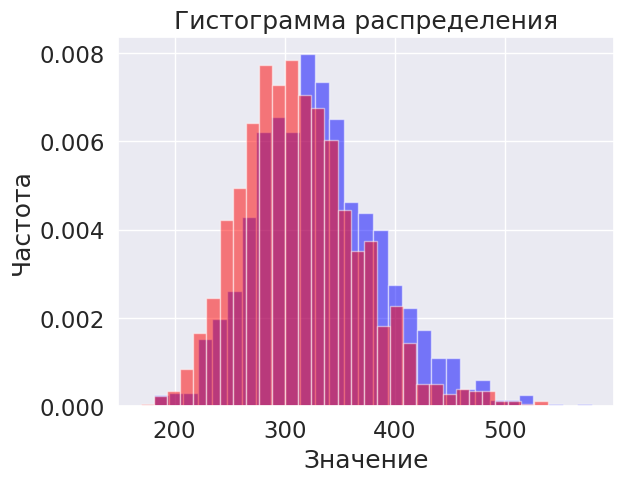

In [ ]:
#distributions for test(red) and control(blue) now
plt.hist(np.array(AB_data.loc[(AB_data['ab_version']=='control'),'value'].values), bins='auto', density = True,color = 'blue',alpha = 0.5)
plt.hist(AB_data.loc[(AB_data['ab_version']=='test'),'value'].values, bins='auto', density = True,color = 'red',alpha=0.5)
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Гистограмма распределения')
plt.grid(True)
plt.show()

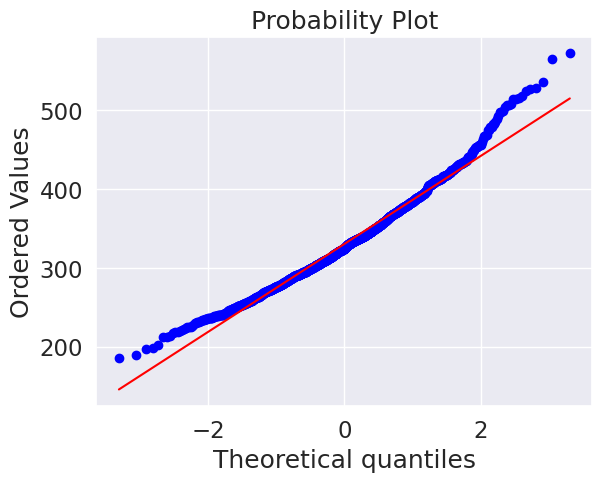

In [ ]:
qq = stats.probplot(AB_data.loc[(AB_data['ab_version']=='test'),'value_before'].values, dist = "norm", plot = plt)
plt.show()

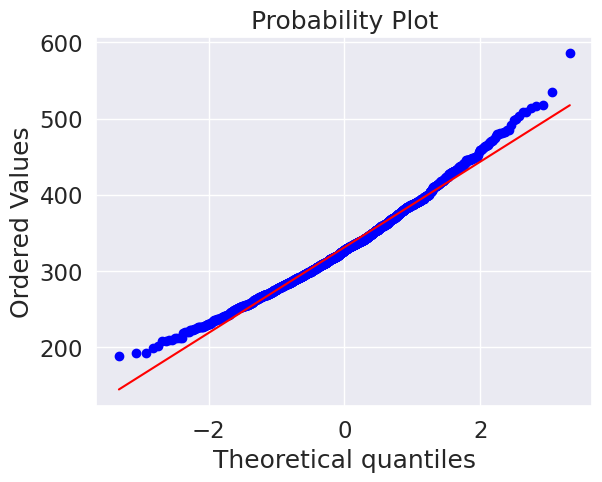

In [ ]:
qq = stats.probplot(AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values, dist = "norm", plot = plt)
plt.show()

In [ ]:
a = AB_data.loc[(AB_data['ab_version']=='control'),'value_before'].values
b = AB_data.loc[(AB_data['ab_version']=='test'),'value_before'].values
print('pvalue: ', stats.f.cdf(np.var(a)/np.var(b),len(a)-1,len(b)-1))

pvalue:  0.6602859624021485


In [ ]:
print("A/A simulation for t-test:\n")
AA_simulation(AB_data,'ttest')

A/A simulation for t-test:



,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.06,0.06,103,0.027786,0.124768
1,0.05,0.03,0.05,148,0.010255,0.084519
2,0.05,0.03,0.04,232,0.010255,0.084519
3,0.05,0.06,0.03,412,0.027786,0.124768
4,0.05,0.07,0.02,927,0.034319,0.137495


In [ ]:
print("A/B simulation for t-test:\n")
AB_simulation(AB_data,'ttest')

A/B simulation for t-test:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.76,0.06,103,0.667677,0.833087
1,0.8,0.78,0.05,148,0.689296,0.849987
2,0.8,0.83,0.04,232,0.744520,0.891064
3,0.8,0.84,0.03,412,0.755797,0.899047
4,0.8,0.78,0.02,927,0.689296,0.849987


In [ ]:
print("A/A simulation for bootstrap:\n")
AA_simulation(AB_data,'bootstrap')

A/A simulation for bootstrap:



,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.06,0.06,103,0.027786,0.124768
1,0.05,0.06,0.05,148,0.027786,0.124768
2,0.05,0.03,0.04,232,0.010255,0.084519
3,0.05,0.03,0.03,412,0.010255,0.084519
4,0.05,0.03,0.02,927,0.010255,0.084519


In [ ]:
print("A/B simulation for bootstrap:\n")
AB_simulation(AB_data,'bootstrap')

A/B simulation for bootstrap:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.84,0.06,103,0.755797,0.899047
1,0.8,0.79,0.05,148,0.700200,0.858343
2,0.8,0.86,0.04,232,0.778628,0.914737
3,0.8,0.88,0.03,412,0.801879,0.930006
4,0.8,0.75,0.02,927,0.656955,0.824548


In [ ]:
print("A/B simulation for cuped t-test:\n")
AB_simulation(AB_data,'cuped_ttest')

A/B simulation for cuped t-test:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,1.0,0.06,103,0.963007,1.0
1,0.8,1.0,0.05,148,0.963007,1.0
2,0.8,1.0,0.04,232,0.963007,1.0
3,0.8,1.0,0.03,412,0.963007,1.0
4,0.8,1.0,0.02,927,0.963007,1.0


In [ ]:
print("A/A simulation for cuped t-test:\n")
AA_simulation(AB_data,'cuped_ttest')

A/A simulation for cuped t-test:



,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.02,0.06,103,0.005502,0.070012
1,0.05,0.01,0.05,148,0.001767,0.054486
2,0.05,0.03,0.04,232,0.010255,0.084519
3,0.05,0.03,0.03,412,0.010255,0.084519
4,0.05,0.02,0.02,927,0.005502,0.070012


In [ ]:
print("A/B simulation for strat t-test:\n")
AB_simulation(AB_data,'strat_ttest','source')

A/B simulation for strat t-test:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.80,0.06,103,0.711171,0.866633
1,0.8,0.86,0.05,148,0.778628,0.914737
2,0.8,0.85,0.04,232,0.767164,0.906940
3,0.8,0.83,0.03,412,0.744520,0.891064
4,0.8,0.79,0.02,927,0.700200,0.858343


In [ ]:
print("A/A simulation for strat t-test:\n")
AA_simulation(AB_data,'strat_ttest','source')

A/A simulation for strat t-test:



,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.02,0.06,103,0.005502,0.070012
1,0.05,0.07,0.05,148,0.034319,0.137495
2,0.05,0.04,0.04,232,0.015663,0.098371
3,0.05,0.04,0.03,412,0.015663,0.098371
4,0.05,0.03,0.02,927,0.010255,0.084519


In [ ]:
print("A/B simulation for strat t-test:\n")
AB_simulation(AB_data,'strat_ttest','device')

A/B simulation for strat t-test:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,0.85,0.06,103,0.767164,0.906940
1,0.8,0.79,0.05,148,0.700200,0.858343
2,0.8,0.79,0.04,232,0.700200,0.858343
3,0.8,0.76,0.03,412,0.667677,0.833087
4,0.8,0.78,0.02,927,0.689296,0.849987


In [ ]:
print("A/A simulation for strat t-test:\n")
AA_simulation(AB_data,'strat_ttest','device')

A/A simulation for strat t-test:



,sig,empirical_sig,mde,sample_size,left_real_level,right_real_level
0,0.05,0.04,0.06,103,0.015663,0.098371
1,0.05,0.05,0.05,148,0.021544,0.111750
2,0.05,0.08,0.04,232,0.041093,0.149981
3,0.05,0.04,0.03,412,0.015663,0.098371
4,0.05,0.02,0.02,927,0.005502,0.070012


In [ ]:
print("A/A simulation for msprt test:\n")
msprt_AA_simulation(AB_data)

A/A simulation for msprt test:



,sig,empirical_sig,sample_size,left_real_level,right_real_level
0,0.05,0.034,1445.6,0.024431,0.047135


In [ ]:
print("A/B simulation for msprt test:\n")
msprt_AB_simulation(AB_data)

A/B simulation for msprt test:



,power,empirical_power,mde,sample_size,left_real_level,right_real_level
0,0.8,1.00,0.06,181.30,0.963007,1.000000
1,0.8,1.00,0.05,235.90,0.963007,1.000000
2,0.8,1.00,0.04,352.92,0.963007,1.000000
3,0.8,0.88,0.03,723.61,0.801879,0.930006
4,0.8,0.53,0.02,1089.90,0.432889,0.624892


In [ ]:
sample_a = AB_data.loc[(AB_data['ab_version']=='control')].sample(413,replace=False)
sample_b = AB_data.loc[(AB_data['ab_version']=='test')].sample(413,replace=False)
a,b = cuped_ttest(sample_a['value'].values,sample_b['value'].values, sample_a['value_before'].values,sample_b['value_before'].values)
absolute_ttest(a,b)

[1.485995095960987e-121, -23.415488879177296]